# **Sistemas Inteligentes: Tarea 3**

## **¿Qué es esto?**

La inteligencia artificial es una disciplina que exige su buena dosis de programación, ya que no hay mejor manera de aprender nuevos conceptos de ingeniería que programándolos. Por ello, la clase de Sistemas Inteligentes requerirá que apliques los conocimientos teóricos que desarrollaste en clase utilizando herramienta muy poderosa llamada Jupyter Notebooks. 

Ahora mismo estás ante la presencia de una Jupyter Notebook. Como puedes ver es un entorno de programación orientado a trabajar en pequeños scripts de código y puedes comentarlo utilizando Markdown + $\LaTeX$. Ésto es particularmente útil porque permite dividir el trabajo (y las actividades evaluadas) en cachos. Una notebook está formada entonces por celdas que pueden ser de código o de Markdown.


In [8]:
print("""Esta es una celda de código (haz click para editarla)
        presiona CTRL + INTRO para ejecutarla o
        presiona SHIFT + INTRO para ejecutarla y
        continuar con la siguiente celda""")

Esta es una celda de código (haz click para editarla)
        presiona CTRL + INTRO para ejecutarla o
        presiona SHIFT + INTRO para ejecutarla y
        continuar con la siguiente celda


Estas descripciones se encuentran en una celda de Markdown, haz doble click para editarlas o ver el código fuente.

El lenguaje de programación que estaremos utilizando es Python; sin embargo, uno puede instalar kernels diferentes que permitan usar otros lenguajes como R y Julia.

## **Sobre esta tarea**

En esta tarea trabajarás sobre un grid para encontrar el camino hacia la meta usando los algoritmos de búsqueda estudiados en clase. La forma de implementar los algoritmos es un tanto diferente a lo que estudiaste en clase, pues en este caso usamos diccionarios de python para almacenar los caminos que genera cada tipo de búsqueda.

Después de completar esta tarea serás capáz de:
- implementar el algoritmo de búsqueda en anchura
- implementar el algoritmo de búsqueda en profundidad
- implementar el algoritmo de búsqueda costo uniforme
- implementar el algoritmo de búsqueda avara
- implementar el algoritmo de búsqueda A*
- aplicar estos algoritmos en un problema de búsqueda

## **1. Búsqueda en anchura**

El algoritmo de búsqueda en anchura explora en todas las direcciones expandiendo todos los nodos vecinos de la frontera hasta llegar al nodo meta.

El algoritmo que vamos a implementar guarda información sobre cada uno de los nodos explorados, específicamente, cuál es su nodo padre. De esta forma es posible hacer un backtracking de la meta hacia el punto de inicio de la búsqueda. Esta información se guarda en un diccionario de python. En la siguiente imagen se muestra una representación gráfica de este diccionario:

![](https://firebasestorage.googleapis.com/v0/b/firescript-577a2.appspot.com/o/imgs%2Fapp%2Frbrt%2F4Bopg8kfFV.png?alt=media&token=a8496731-4562-47ab-93d6-63f18adefa21)

Las siguientes clases definen las estructuras de datos que vamos a utilizar para encontrar el camino hacia la meta en un laberinto formado por celdas cuadradas. Veamos primero cómo se forma la estructura que almacena la información sobre la frontera de búsqueda.

In [9]:
import collections

class Queue:
    """Clase para implementar una lista FIFO"""
    def __init__(self):
        self.elements = collections.deque()
    
    def empty(self):
        return len(self.elements) == 0
    
    def put(self, x):
        self.elements.append(x)
    
    def get(self):
        """Regresa el objeto más antiguo"""
        return self.elements.popleft()

Ahora, generaremos un objeto que represente el grid de búsqueda. Para ello necesitamos definir un parámetro de tamaño y otro para los obstáculos o paredes que pueda tener. Además, sería muy práctico que sus métodos ayudaran a identificar los nodos hijos para ir generando el árbol de búsqueda. Este objeto es análogo al grafo que estuviste estudiando en clase, donde los nodos son tuples de python que indican posición horizontal y vertical comenzando en 1 de izquierda a derecha y de abajo hacia arriba (i.e. `nodo1 = (x1, y1)`). Finalmente, también agregamos un método que nos permita representar gráficamente tanto el grid como la meta y la trayectoria calculada por el algoritmo.


In [10]:
class SquareGrid:
    """A class to represent a grid map with obstacles."""
    def __init__(self, width, height):
        self.width = width
        self.height = height
        self.walls = []
    
    def in_bounds(self, id):
        (x, y) = id
        return 0 < x <= self.width and 0 < y <= self.height
    
    def passable(self, id):
        return id not in self.walls   # not passable nodes are walls
    
    def neighbors(self, id):
        """Return neighboring passable nodes."""
        (x, y) = id
        results = [(x+1, y), (x, y-1), (x-1, y), (x, y+1)]
        if (x + y) % 2 == 0: results.reverse() # aesthetics
        results = filter(self.in_bounds, results)
        results = filter(self.passable, results)
        return results
    
    def draw(self, goal=None, route=None):
        """Print a representation of the grid."""
        grid = [[' . ' for _ in range(self.width)] for _ in range(self.height)]
        
        def modify_grid(symbol, i, j):
            grid[self.height - j][i - 1] = symbol 

        for node in self.walls:
            modify_grid(' # ', *node)

        if goal:
            modify_grid(' X ', *goal)

        # print the directions traversed along a route
        if route:
            comes = route[goal]
            goes = goal
            step = 0
            while comes: 
                x1, y1 = comes
                x2, y2 = goes
                xdir = x2 - x1
                ydir = y2 - y1
                if xdir > 0:
                    modify_grid(' > ', *comes)
                elif xdir < 0:
                    modify_grid(' < ', *comes)
                elif ydir > 0:
                    modify_grid(' ^ ', *comes)
                else:
                    modify_grid(' v ', *comes)
                goes = comes
                comes = route[comes]
                step += 1
            print("Number of steps:", step)

        for row in grid:
            print(''.join(row))

El siguiente grid cuadrado representa el laberinto sobre el cual estarás trabajando en esta tarea. El objetivo de cada algoritmo de búsqueda será trazar la ruta desde la esquina inferior izquierda (i.e. nodo `(1, 1)`), hasta la meta marcada por una X (nodo `(12, 12)`).

In [11]:
grid = SquareGrid(23, 23)
start = (1, 1)
goal = (12, 12)
grid.walls = [(5, 8), (6, 7), ( 1, 23), ( 2, 23), ( 3, 23), ( 4, 23), ( 5, 23), ( 6, 23), ( 7, 23), ( 8, 23), ( 1, 22), ( 2, 22), ( 3, 22), ( 4, 22), ( 5, 22), ( 6, 22), ( 7, 22), ( 5, 21), ( 6, 21), ( 10, 21), ( 11, 21), ( 12, 21), ( 13, 21), ( 14, 21), ( 19, 21), ( 20, 21), ( 21, 21), ( 9, 20), ( 15, 20), ( 19, 20), ( 20, 20), ( 21, 20), ( 3, 19), ( 8, 19), ( 16, 19), ( 20, 19), ( 21, 19), ( 3, 18), ( 4, 18), ( 7, 18), ( 11, 18), ( 12, 18), ( 13, 18), ( 15, 18), ( 16, 18), ( 17, 18), ( 20, 18), ( 21, 18), ( 4, 17), ( 5, 17), ( 6, 17), ( 10, 17), ( 14, 17), ( 15, 17), ( 16, 17), ( 17, 17), ( 20, 17), ( 21, 17), ( 1, 16), ( 5, 16), ( 9, 16), ( 20, 16), ( 21, 16), ( 8, 15), ( 12, 15), ( 20, 15), ( 21, 15), ( 3, 14), ( 7, 14), ( 11, 14), ( 13, 14), ( 17, 14), ( 18, 14), ( 19, 14), ( 20, 14), ( 21, 14), ( 4, 13), ( 6, 13), ( 10, 13), ( 14, 13), ( 18, 13), ( 19, 13), ( 20, 13), ( 21, 13), ( 1, 12), ( 5, 12), ( 9, 12), ( 15, 12), ( 19, 12), ( 21, 12), ( 2, 11), ( 6, 11), ( 14, 11), ( 18, 11), ( 3, 10), ( 7, 10), ( 13, 10), ( 17, 10), ( 4, 9), ( 8, 9), ( 12, 9), ( 16, 9), ( 20, 9), ( 9, 8), ( 15, 8), ( 21, 8), ( 10, 7), ( 14, 7), ( 18, 7), ( 22, 7), ( 3, 6), ( 7, 6), ( 11, 6), ( 13, 6), ( 17, 6), ( 19, 6), ( 23, 6), ( 4, 5), ( 8, 5), ( 12, 5), ( 16, 5), ( 20, 5), ( 5, 4), ( 9, 4), ( 13, 4), ( 15, 4), ( 21, 4), ( 6, 3), ( 10, 3), ( 14, 3), ( 18, 3), ( 3, 2), ( 17, 2), ( 18, 2), ( 19, 2), ( 3, 1), ( 4, 1), ( 8, 1), ( 12, 1), ( 16, 1), ( 17, 1), ( 18, 1), ( 19, 1), ( 20, 1), ( 21, 1), ( 22, 1), ( 23, 1) ]
grid.draw(goal=goal)

 #  #  #  #  #  #  #  #  .  .  .  .  .  .  .  .  .  .  .  .  .  .  . 
 #  #  #  #  #  #  #  .  .  .  .  .  .  .  .  .  .  .  .  .  .  .  . 
 .  .  .  .  #  #  .  .  .  #  #  #  #  #  .  .  .  .  #  #  #  .  . 
 .  .  .  .  .  .  .  .  #  .  .  .  .  .  #  .  .  .  #  #  #  .  . 
 .  .  #  .  .  .  .  #  .  .  .  .  .  .  .  #  .  .  .  #  #  .  . 
 .  .  #  #  .  .  #  .  .  .  #  #  #  .  #  #  #  .  .  #  #  .  . 
 .  .  .  #  #  #  .  .  .  #  .  .  .  #  #  #  #  .  .  #  #  .  . 
 #  .  .  .  #  .  .  .  #  .  .  .  .  .  .  .  .  .  .  #  #  .  . 
 .  .  .  .  .  .  .  #  .  .  .  #  .  .  .  .  .  .  .  #  #  .  . 
 .  .  #  .  .  .  #  .  .  .  #  .  #  .  .  .  #  #  #  #  #  .  . 
 .  .  .  #  .  #  .  .  .  #  .  .  .  #  .  .  .  #  #  #  #  .  . 
 #  .  .  .  #  .  .  .  #  .  .  X  .  .  #  .  .  .  #  .  #  .  . 
 .  #  .  .  .  #  .  .  .  .  .  .  .  #  .  .  .  #  .  .  .  .  . 
 .  .  #  .  .  .  #  .  .  .  .  .  #  .  .  .  #  .  .  .  .  .  . 
 .  .  .  #  .  .  .

**Challenge 1. (10 pts.)** A continuación, se define la función que encuentra el nodo meta usando el algoritmo de búsqueda en anchura. Fíjate como la función regresa un diccionario con la siguiente estructura de valores: `came_from = {(nodo inicial): None, (nodo hijo): (nodo padre), ... (nodo meta): (nodo padre), ...}`. 

El ejercicio es generar esta estructura iterando sobre los nodos hijos del nodo que está siendo expandido (`current`) y agregando el nodo hijo a la frontera y al diccionario `came_from` en caso de que sea un nodo no explorado previamente.



In [12]:
def breadth_first_search(graph, start, goal):
    """Search for path along an expanding frontier."""
    frontier = Queue()
    frontier.put(start)   # start position is the first node
    came_from = {}        # stores the parent node
    came_from[start] = None
    
    while not frontier.empty():
        current = frontier.get()
        
        # parar la ejecución cuando se llegue a la meta
        if current == goal:
            break
          
        #=========== Challenge 1 =============
        # Uncomment all the for loop
        # And complete the if statement
        #for next in graph.neighbors(current):
            # if next no ha sido visitado o explorado previamente
            # if ...
                #frontier.put(next)
                #came_from[next] = current
        #====================================

    return came_from

Corremos el algoritmo de BFS sobre el grid de $23\times23$ que generamos.

El Expected Output es:

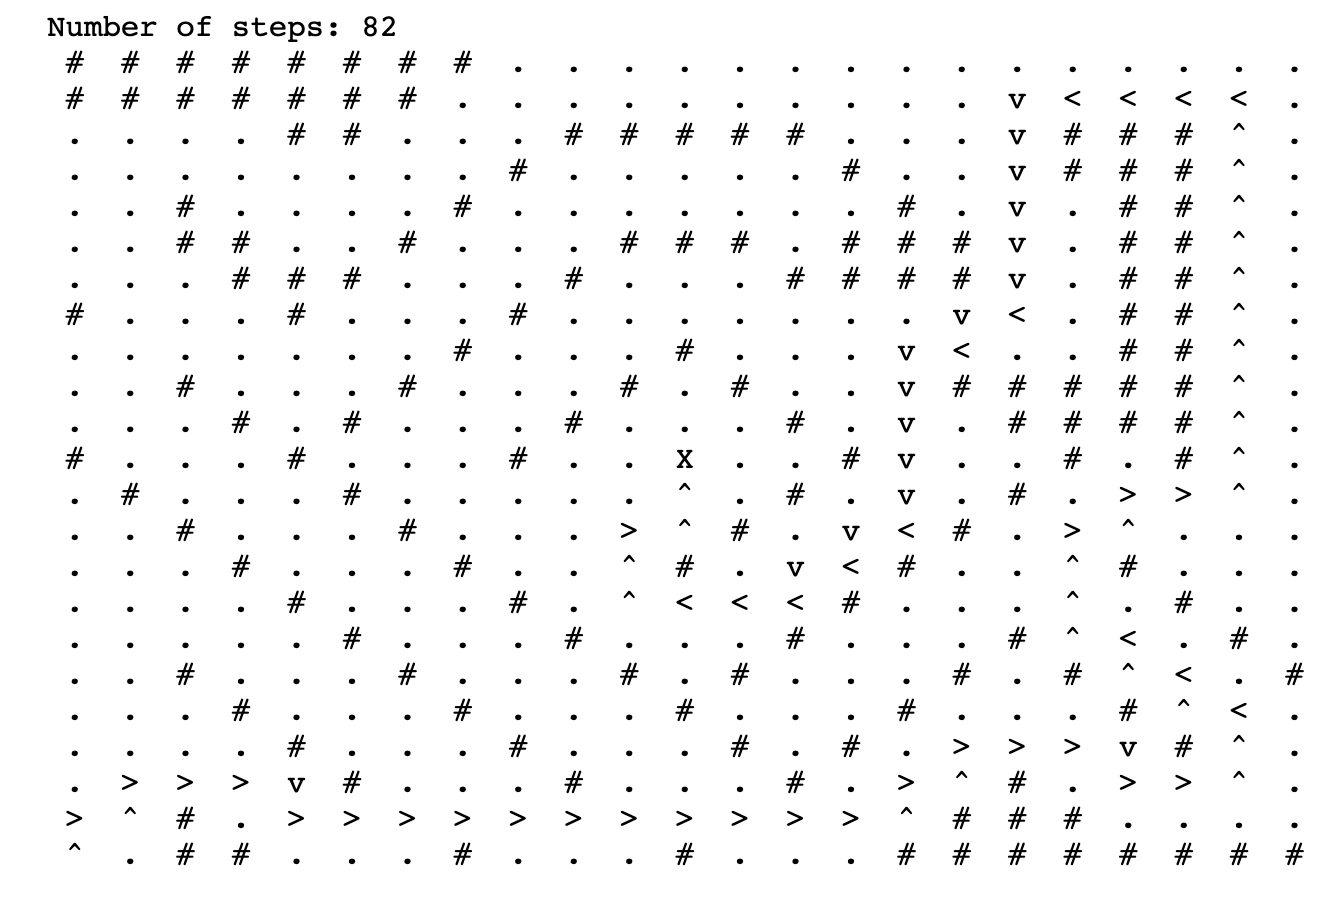


In [13]:
came_from=breadth_first_search(grid, start, goal)
grid.draw(goal, came_from)

KeyError: (12, 12)

## **2. Búsqueda en profundidad**

La búsqueda en profundidad expande los nodos de la frontera con una prioridad muy diferente, en la que se brinca de nodo padre a nodo hijo hasta llegar al nivel más profundo o encontrar la solución. Cuando no se encuentra la solución se toma un nodo hermano y si no un hermano del padre o así sucesivamente de manera recursiva.

Suena bastante diferente de BFS, pero la realidad es que el algoritmo en sí es casi idéntico. La pieza clave en donde difieren es el tipo de estructura de datos en el que se guardan los nodos de la frontera de búsqueda. En el caso de DFS, los nodos más recientes son los que se exploran primero, esto permite observar el comportamiento recursivo que se mencionó anteriormente.

**Challenge 2. (10 pts.)** Diseña una estructura de tipo LIFO similar a como se hizo con `Queue` para implementar la búsqueda en anchura. 

Tip: fíjate de qué extremo de la lista se extraen los elementos en `Queue` y haz lo contrario con `Stack`

In [14]:
class Stack:
    """Clase para implementar una lista LIFO, it returns the last input"""
    
    #=========== Challenge 2 =============
    #def __init__(self):
    #    ...
    #def empty(self):
    #    ...
    #def put(self, x):
    #    ...
    #def get(self):
    #    ...
    #====================================
    

Diseñamos la función de búsqueda en profundidad sin ninguna modificación respecto a BFS, salvo que ahora la frontera de búsqueda está modelada con un `Stack`, lo cual generará el comportamiento de búsqueda que esperamos.

**Challenge 3. (10 pts.)** Diseña una estructura de tipo LIFO similar a como se hizo con `Queue` para implementar la búsqueda en anchura. Tip: fíjate de qué extremo de la lista se extraen los elementos en `Queue` y haz lo contrario con `Stack`

In [15]:
def depth_first_search(graph, start, goal):
    """Search for path along an expanding frontier."""
    frontier = Stack()
    frontier.put(start)   # start position is the first node
    came_from = {}        # stores the parent node
    came_from[start] = None
    
    while not frontier.empty():
        current = frontier.get()
        
        if current == goal:
            break

        #=========== Challenge 3 =============
        # Uncomment the for loop
        # And complete the three lines for Deep-first Search
        #for ... each of the succesors
            #if ... the succesor has not been explored
                # ... add the succesor to the frontier stack
                # ... add the succesor to the came_from dictionary with the parent cell
    
    return came_from

Corremos el algoritmo de búsqueda en profundidad sobre el grid original.

El Expected Output es:

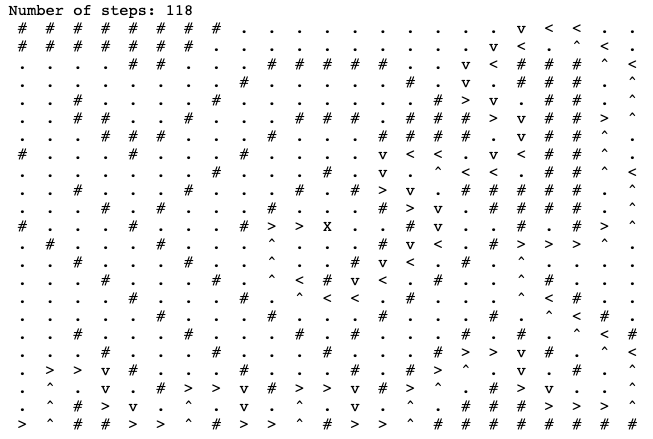

In [16]:
came_from=depth_first_search(grid, start, goal)
grid.draw(goal, came_from)

AttributeError: 'Stack' object has no attribute 'put'

## **3. Búsqueda costo uniforme**

La búsqueda de costo uniforme es similar a la búsqueda en anchura, sólo que ahora cada nodo tiene asociado un costo. Por ejemplo, si el *grid* se está usando para implementar un mapa en un videojuego, un nodo que representa un espacio de suelo podría tener un costo menor que uno que representa agua. 


Al igual que con la búsqueda de anchura, se almacena el nodo padre de cada nodo visitado para representar las rutas. Sin embargo, ahora tenemos que almacenar el costo acumulado hasta el nodo actual, en vez de sólo buscar la ruta más corta. Debido a eso, implementamos una clase de `PriorityQueue` que almacene el costo total asociado a cada ruta y permita accesar la de menor costo de forma eficiente.

Además, también tenemos que considerar que puede haber varias rutas que lleven al mismo nodo, cada una con un costo asociado distinto. Por esto, cada vez que se expande la frontera es necesario comparar el costo de las rutas nuevas con las previamente encontradas y mantener las de menor costo.

Las siguientes clases implementan el *grid* con costos por nodo y el `PriorityQueue`.

Lo primero que necesitamos es definir los costos de cada operación, para ello generamos una nueva clase que herede los atributos de `SquareGrid` y añada el diccionario `weights` que mapee cada celda a un valor de costo.

In [17]:
class GridWithWeights(SquareGrid):
    """A class to represent a grid with weights."""
    def __init__(self, width, height):
        super().__init__(width, height)
        self.weights = {}
    
    def cost(self, from_node, to_node):
        return self.weights.get(to_node, 1)

Este algoritmo necesita una lista priorizada para expandir los nodos de menor costo acumulado. La siguiente estructura permite mantener ordenados los elementos para poder extraer el elemento de menor prioridad (en este caso menor costo acumulado) de la lista. 

In [18]:
import heapq

class PriorityQueue:
    """A class to implement priority queues.
    Each node is less or equal to its children, and the root
    is the smallest value in the queue.
    """
    def __init__(self):
        self.elements = []
    
    def empty(self):
        return len(self.elements) == 0
    
    def put(self, item, priority):
        heapq.heappush(self.elements, (priority, item))
    
    def get(self):
        """Return item with smallest priority value."""
        return heapq.heappop(self.elements)[1]

**Challenge 4. (10 pts.)** En el caso de este algoritmo, se necesita mantener registro tanto del nodo padre de cada sucesor como de su costo acumulado. En la siguiente función, calcula el costo acumulado del sucesor. 

Tip: utiliza el costo acumulado del nodo que se está expandiendo y el costo del sucesor de acuerdo al grid de pesos.

In [19]:
def dijkstra_search(graph, start, goal):
    """Search for least costly path along an expanding frontier."""
    frontier = PriorityQueue()
    frontier.put(start, 0)    # start position has cost 0
    came_from = {}            # stores the parent node
    cost_so_far = {}          # cost from start to current node
    came_from[start] = None
    cost_so_far[start] = 0
    
    while not frontier.empty():
        current = frontier.get()
        
        if current == goal:
            break
        
        for next in graph.neighbors(current):
            #=========== Challenge 4 =============
            #new_cost = ...
            #=====================================
            
            # ignore already traversed nodes unless new route is less costly
            if next not in cost_so_far or new_cost < cost_so_far[next]:
                cost_so_far[next] = new_cost
                priority = new_cost
                frontier.put(next, priority)
                came_from[next] = current     # assign current node as parent
    
    return came_from, cost_so_far

Generamos el nuevo grid con pesos y corremos el algoritmo de Dijkstra.

El Expected Output es:

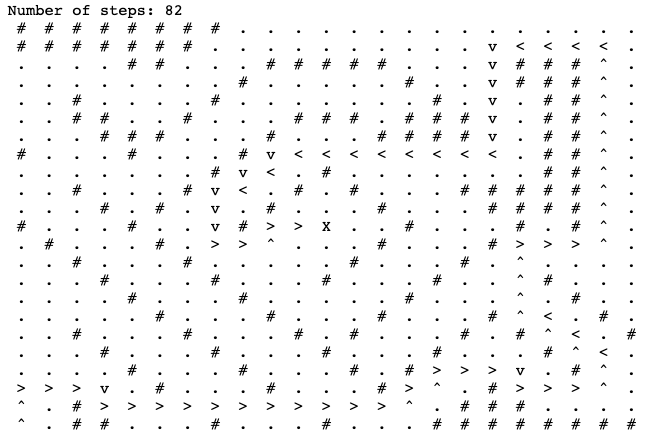

In [20]:
diagram4 = GridWithWeights(grid.width, grid.height)
diagram4.walls = grid.walls
diagram4.weights = {(x, y):1 for x in range(grid.width+1) for y in range(grid.height+1)}
came_from, cost_so_far = dijkstra_search(diagram4, start, goal)
diagram4.draw(route=came_from, goal=goal)

NameError: name 'new_cost' is not defined

**Challenge 5. (20 pts.)** Cambiar los costos o pesos (weights) de cada paso para lograr generar la siguiente salida (o algo parecido que suba por el lado izquierdo! ... en lugar de que suba por el lado derecho como en el caso anterior!)

El Expected Output es:

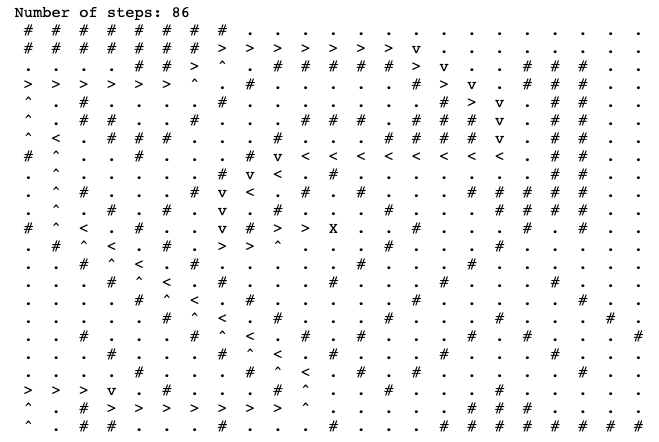

In [21]:

diagram4 = GridWithWeights(grid.width, grid.height)
diagram4.walls = grid.walls
#=========== Challenge 5 =============================
# Here the step costs are unitary, you need to change
# them to non-unitary costs ...
# Change the step costs to achieve the desired route!
#=====================================================
diagram4.weights = {(x, y):1 for x in range(grid.width+1) for y in range(grid.height+1)}
came_from, cost_so_far = dijkstra_search(diagram4, start, goal)
diagram4.draw(route=came_from, goal=goal)

NameError: name 'new_cost' is not defined

## **4. Búsqueda avara**

Para la búqueda avara, se utiliza una heurística para estimar la mejor ruta a un objetivo. A diferencia de la búsqueda con costo uniforme, donde se consideraba la distancia desde el nodo actual hasta el nodo inicial, en este algoritmo se considera la distancia del nodo actual hasta el objetivo.

Si hay pocos obstáculos, esta es una buena opción, porque encuentra la ruta más directa. Sin embargo, este algoritmo puede llevar a rutas más largas si hay más obstáculos, en comparación a las rutas encontradas por el algoritmo de búsqueda por costo uniforme.

La implementación es muy similar a la de búsqueda de costo uniforme, sólo que se almacena el valor de la heurística para cada ruta en vez del costo acumulado.

**Challenge 6 (15 pts.)** Diseña una buena función heurística para aproximar el costo entre el punto "a" y el punto "b" (implementa la Distancia Manhattan!).

In [22]:
def heuristic(a, b):
    """Return estimated cost between two points."""
    
    (x1, y1) = a
    (x2, y2) = b
    #=========== Challenge 6 =============
    #heuristica = ...
    #=====================================
    
    return heuristica

**Challenge 7 (15 pts.)** Determina e implementa:
- a) qué tipo de lista se ocupa para monitorear la frontera de búsqueda. Recuerda que la estructura de datos que necesites ya fue definida en alguna celda anterior 
- b) completa la parte del código.

In [23]:
def greedy_search(graph, start, goal):
    """Search for smaller heuristic path.""" 
    #=========== Challenge 7.a =============
    #frontier = ...
    #frontier.put ...
    #=======================================

    came_from = dict()
    came_from[start] = None

    while not frontier.empty():
        current = frontier.get()

        if current == goal:
            break
        
        for next in graph.neighbors(current):
            if next not in came_from:
                priority = heuristic(goal, next)
                #=========== Challenge 7.b ===============
                #frontier.put ...
                #came_from ...
                #=========================================
    
    return came_from

Corremos el algoritmo sobre el grid original.

El Expected Output es:

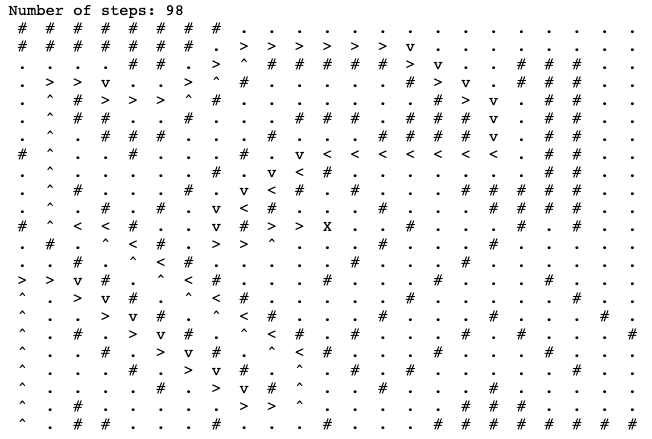

In [24]:
came_from = greedy_search(grid, start, goal)
grid.draw(route=came_from, goal=goal)

NameError: name 'frontier' is not defined

## **5. Búsqueda A***

Este algoritmo es algo como una combinación de la búsqueda por costo uniforme y la avara. Toma en cuenta tanto el costo acumulado hasta el nodo actual, como el costo estimado del nodo actual hasta el objetivo. Gracias a esto, en general es más rápido que la búsqueda por costo uniforme y encuentra mejores rutas que la búsqueda avara.


Debido a eso, la implementación es muy similar a la de búsqueda por costo uniforme, sólo que se le agrega la heurística para estimar el costo hasta el objetivo. Al sumar ambos, se obtiene una estimación del costo total de una ruta.

**Challenge 8. (10 pts.)** Calcula la función de evaluación que permite que el algoritmo de búsqueda A* priorice su lista de nodos a la frontera y encuentre el camino más óptimo.

In [25]:
def a_star_search(graph, start, goal):
    """Search for least costly path along expanding frontier with heuristic.""" 
    frontier = PriorityQueue()
    frontier.put(start, 0)    # start position has cost 0
    came_from = {}            # stores the parent node
    cost_so_far = {}          # cost from start to current node
    came_from[start] = None
    cost_so_far[start] = 0
    
    while not frontier.empty():
        current = frontier.get()
        
        if current == goal:
            break
        
        for next in graph.neighbors(current):
            new_cost = cost_so_far[current] + graph.cost(current, next)
            # ignore already traversed nodes unless new route is less costly
            if next not in cost_so_far or new_cost < cost_so_far[next]:
                cost_so_far[next] = new_cost
                #=========== Challenge 8 =============
                #priority = ... (fev)
                #=====================================

                frontier.put(next, priority)
                came_from[next] = current
    
    return came_from, cost_so_far

Corremos el algoritmo con el grid que tiene los pesos.

El Expected Output es:

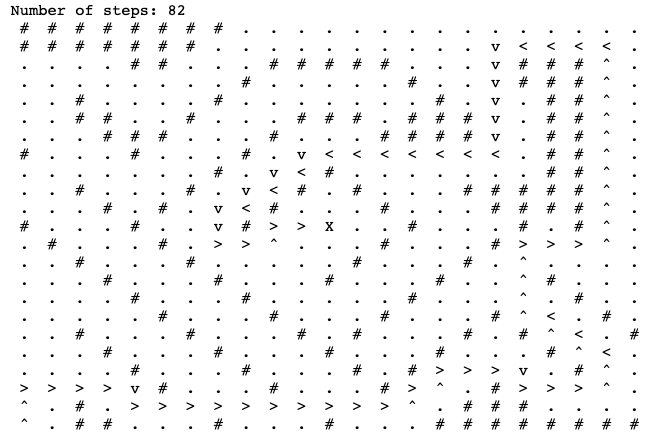

In [26]:
diagram4.weights = {(x, y):1 for x in range(grid.width+1) for y in range(grid.height+1)}
came_from, cost_so_far = a_star_search(diagram4, start, goal)
diagram4.draw(route=came_from, goal=goal)

NameError: name 'priority' is not defined


## **Conclusiones**


**Rethorical Final Challenge. (Required!)** Anota el número de pasos de la solución de cada algoritmo (el número que se imprime arriba del grid en cada corrida) en la lista `steps` para graficar el número de pasos en función del algoritmo. Después compara estos valores y atribuyelos al proceso detrás de cada algoritmo. 

### **IMPORTANTE:**

Este paso no es calificado, pero sí es requisito para calificar lo demás! ... Puede ganar estrella extra el que tenga excelentes comentarios acerca del comportamiento!

- Debe mostrar la gráfica con los números de pasos.
- Añadir en la última celda de texto sus comentarios del "por qué" se comporta así cada algoritmo!


ValueError: shape mismatch: objects cannot be broadcast to a single shape

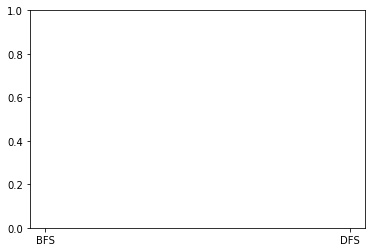

In [27]:
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np

#=========== Actividad 6 =============
#steps = [steps_bfs, steps_dfs, steps_dijkstra_unitary, setps_dijkstra_non-unitary, steps_greedy, steps_astar]
#=====================================

steps = [] 

names = ["BFS", "DFS", "Dij unit", "Dij non-uni","Greedy", "A*"]

plt.bar(names, steps)
plt.show()

# **Tus comentarios del comportamiento:**

- Breadth-first:
- Depth-first:
- Uniform-cost (Dijkstra):
- Greedy:
- A*:
